In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.dates as mdates


In [119]:
#read the file tech_review_channels.tsv.gz
Tch_chan = pd.read_pickle("tech_review_channels (1).p",compression='gzip')
Tech_videos = pd.read_csv('yt_tech_channels_metadata.tsv.gz',compression='infer',sep='\t')
TS = pd.read_table("df_timeseries_en.tsv")

In [120]:
#Write a function that gives the last date a video was uploaded to a channel
def last_upload_date(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['upload_date'].max()




In [121]:
#Now the first date a video was uploaded to a channel
def first_upload_date(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['upload_date'].min()

In [122]:
#It returns the number of months between two dates
def months_between_dates(date1,date2):
    return (date2.year-date1.year)*12 + (date2.month-date1.month)

In [123]:
#find the number of videos displayed on a channel
def num_videos(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['display_id'].count()

In [124]:
#Find the last upload date for each channel
Tch_chan['last_upload_date'] = Tch_chan['channel_id'].apply(last_upload_date)

In [125]:
#Add column last upload date to Tch_chan
Tch_chan['first_upload_date'] = Tch_chan['channel_id'].apply(first_upload_date)

In [126]:
#Add column months between first and last upload date
Tch_chan['months_between_dates'] = Tch_chan.apply(lambda x: months_between_dates(pd.to_datetime(x['first_upload_date']),pd.to_datetime(x['last_upload_date'])),axis=1)

In [127]:
#gIVE THE monthly frequency of uploads as a new column
Tch_chan['monthly_frequency'] = Tch_chan.apply(lambda x:  x['count_tech_videos']/max(1,x['months_between_dates']),axis=1)

In [128]:
#Took the columns that we will use to be faster
Tch_chan_freq = Tch_chan[['channel_id','subscribers_cc' ,'subscriber_rank_sb' ,'monthly_frequency']]

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/3760031346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)


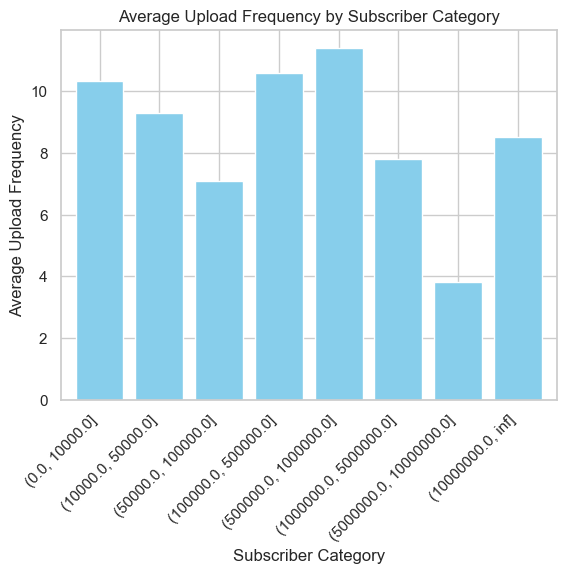

In [129]:
bin_edges = [0, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, float('inf')]

# Create a new column to categorize subscribers into bins
Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)

# Group by the 'Subscriber Category' and calculate the average upload frequency
average_uploads_by_subscribers = Tch_chan_freq.groupby('Subscriber Category')['monthly_frequency'].mean()

# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='skyblue')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [130]:
#Divide youtubers into percentiles based on their subscriber rank
Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/2852373613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)


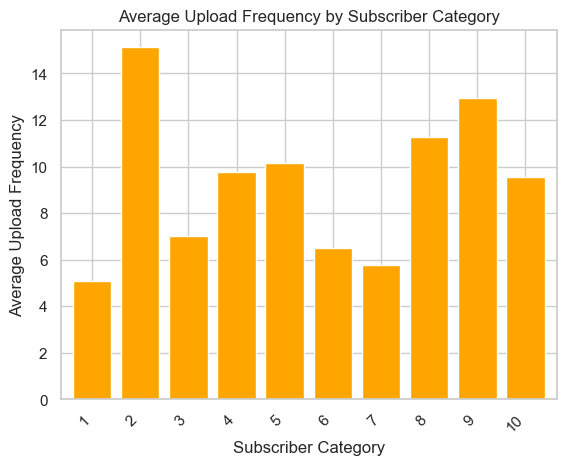

In [131]:
# Group by the 'Rank Category' and calculate the average upload frequency, the cateogry 10 is the top 10% of §ubscribers
average_uploads_by_subscribers = Tch_chan_freq.groupby('Rank Category')['monthly_frequency'].mean()
# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='orange')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Here in those two plots , I divided the tech youtubers within bings, using two metrics (numerical tresholds and percentiles), and measured the average upload frequency depending where they are, we can observe that youtubers that upload the less are small youtubers (0-10th percentile), as they are only doing it for hobby and probably have something else besides youtube, this augments clearly when they are in the 2nd bin, because they are putting a lot of efforts to be known and followed, so they have to push a lot of videos to be seen the most possible. Afterwards this upload frequency is surrounding 7 videos per week , that is here about 2 videos per week , and that's what common youtubers do in general, this frequency increases again for top tier youtubers, and this is probably because it's their main job (this is told by personal knowledge). The trend is the same as in the first plot , and we want to focus more on detail to see if there is a correlation or not between the frequency and the number of subscribers

# Now , focus only on 4 youtubers , this will be generalized over bunch of youtubers for each category 


In [132]:
mylist =['Marques Brownlee','UrAvgConsumer','Unbox Therapy','Mrwhosetheboss']
list_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ 'channel_id'].unique()
names_and_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ ['name_cc' ,'channel_id']].drop_duplicates()
names_and_ids  

,name_cc,channel_id
0,Unbox Therapy,UCsTcErHg8oDvUnTzoqsYeNw
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ
12,Mrwhosetheboss,UCMiJRAwDNSNzuYeN2uWa0pA
19,UrAvgConsumer,UC9fSZHEh6XsRpX-xJc6lT3A


In [133]:
Tech_4_VID = Tech_videos[Tech_videos['channel_id'].isin(list_ids)]

In [134]:
Tech_4_VID['Release_Date'] = pd.to_datetime(Tech_4_VID['upload_date'])
# Sort the DataFrame by 'Release_Date'
Tech_4_VID = Tech_4_VID.sort_values('Release_Date')

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/3062517267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tech_4_VID['Release_Date'] = pd.to_datetime(Tech_4_VID['upload_date'])


In [145]:
TS_4 = TS[TS['channel'].isin(list_ids)]
Tech_4_VID_flt =Tech_4_VID[(TS_4['datetime'].max() >=Tech_4_VID['Release_Date']) & (Tech_4_VID['Release_Date']>= TS_4['datetime'].min())]

#Divided the table into one for each channel
UnboxVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCsTcErHg8oDvUnTzoqsYeNw']
MKBHDVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCBJycsmduvYEL83R_U4JriQ']
UrAvgConsumerVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UC9fSZHEh6XsRpX-xJc6lT3A']
MrwhosethebossVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCMiJRAwDNSNzuYeN2uWa0pA'] 

MKBHDVID['Youtuber'] = 'MKBHD'
UnboxVID['Youtuber'] = 'Unbox Therapy'
UrAvgConsumerVID['Youtuber'] = 'UrAverageConsumer'
MrwhosethebossVID['Youtuber'] = 'MrWhoseTheBoss'


#Put the days in order 
MKBHDVID = MKBHDVID.sort_values('Release_Date')
UnboxVID = UnboxVID.sort_values('Release_Date')
UrAvgConsumerVID = UrAvgConsumerVID.sort_values('Release_Date')
MrwhosethebossVID = MrwhosethebossVID.sort_values('Release_Date')

MKBHDVID['Year'] = MKBHDVID['Release_Date'].dt.year
MKBHDVID['Month'] = MKBHDVID['Release_Date'].dt.month
UnboxVID['Year'] = UnboxVID['Release_Date'].dt.year
UnboxVID['Month'] = UnboxVID['Release_Date'].dt.month
UrAvgConsumerVID['Year'] = UrAvgConsumerVID['Release_Date'].dt.year
UrAvgConsumerVID['Month'] = UrAvgConsumerVID['Release_Date'].dt.month
MrwhosethebossVID['Year'] = MrwhosethebossVID['Release_Date'].dt.year
MrwhosethebossVID['Month'] = MrwhosethebossVID['Release_Date'].dt.month

#Difference between release days MKBHD
MKBHDVID['diff'] = MKBHDVID['Release_Date'].diff().dt.days
UnboxVID['diff'] = UnboxVID['Release_Date'].diff().dt.days
UrAvgConsumerVID['diff'] = UrAvgConsumerVID['Release_Date'].diff().dt.days
MrwhosethebossVID['diff'] = MrwhosethebossVID['Release_Date'].diff().dt.days

#set nan to 1
MKBHDVID['diff'] = MKBHDVID['diff'].fillna(1)
UnboxVID['diff'] = UnboxVID['diff'].fillna(1)
UrAvgConsumerVID['diff'] = UrAvgConsumerVID['diff'].fillna(1)
MrwhosethebossVID['diff'] = MrwhosethebossVID['diff'].fillna(1)

#set 0 to 1/2
MKBHDVID['diff'] = MKBHDVID['diff'].replace(0,0.5)
UnboxVID['diff'] = UnboxVID['diff'].replace(0,0.5)
UrAvgConsumerVID['diff'] = UrAvgConsumerVID['diff'].replace(0,0.5)
MrwhosethebossVID['diff'] = MrwhosethebossVID['diff'].replace(0,0.5)

#Calculate frequency = 1/diff
MKBHDVID['Frequency'] = 1/MKBHDVID['diff']
UnboxVID['Frequency'] = 1/UnboxVID['diff']
UrAvgConsumerVID['Frequency'] = 1/UrAvgConsumerVID['diff']
MrwhosethebossVID['Frequency'] = 1/MrwhosethebossVID['diff']

MKBHDVID['MonthlyFrequencyVAR'] = MKBHDVID.groupby(['Year','Month'])['Frequency'].transform('var')
UnboxVID['MonthlyFrequencyVAR'] = UnboxVID.groupby(['Year','Month'])['Frequency'].transform('var')
UrAvgConsumerVID['MonthlyFrequencyVAR'] = UrAvgConsumerVID.groupby(['Year','Month'])['Frequency'].transform('var')
MrwhosethebossVID['MonthlyFrequencyVAR'] = MrwhosethebossVID.groupby(['Year','Month'])['Frequency'].transform('var')



/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/438723015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MKBHDVID['Youtuber'] = 'MKBHD'
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/438723015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UnboxVID['Youtuber'] = 'Unbox Therapy'
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/438723015.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 3000x1700 with 0 Axes>

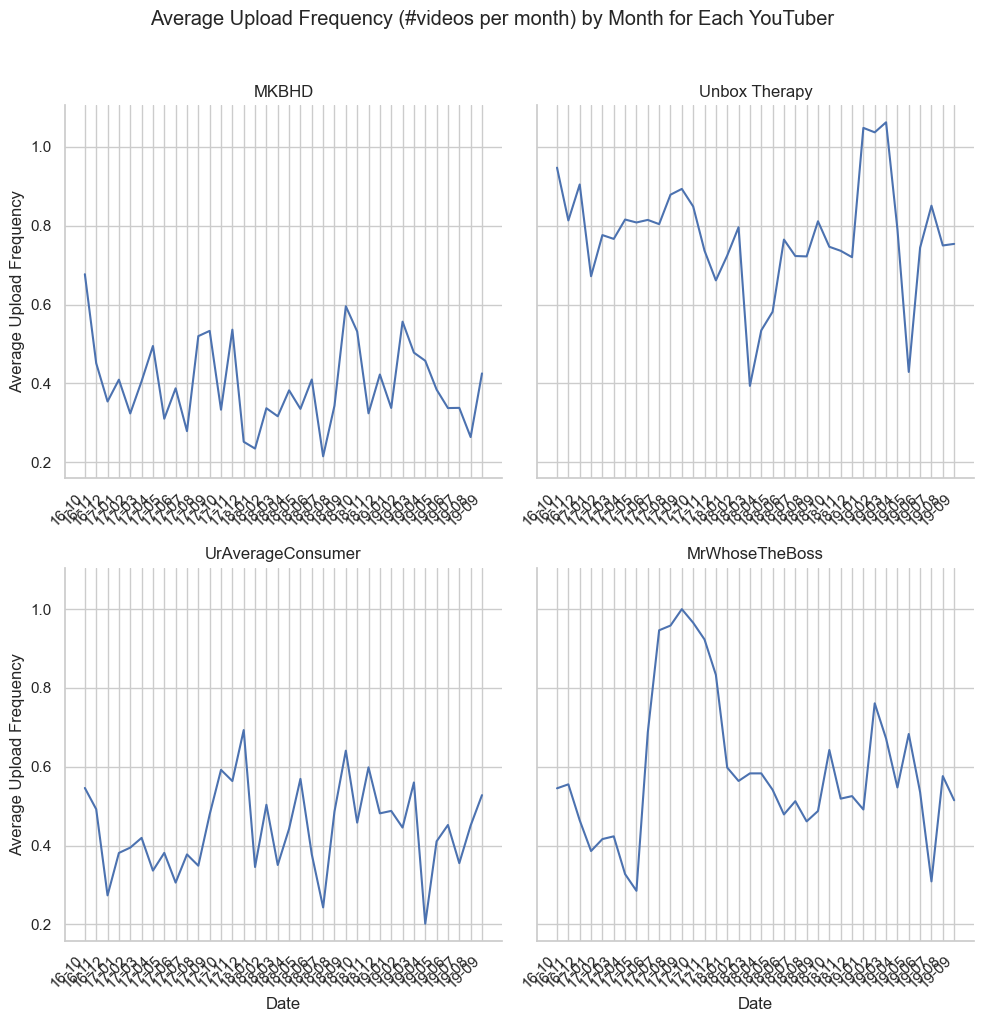

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have four DataFrames: youtuber1_df, youtuber2_df, youtuber3_df, youtuber4_df

# Add a 'Youtuber' column to each DataFrame
MKBHDVID['Youtuber'] = 'MKBHD'
UnboxVID['Youtuber'] = 'Unbox Therapy'
UrAvgConsumerVID['Youtuber'] = 'UrAverageConsumer'
MrwhosethebossVID['Youtuber'] = 'MrWhoseTheBoss'

# Combine the DataFrames into one
combined_df_freq = pd.concat([MKBHDVID, UnboxVID, UrAvgConsumerVID, MrwhosethebossVID])

combined_df_freq['FormattedDate'] = combined_df_freq['Release_Date'].dt.strftime('%y-%m')

plt.figure(figsize=(30, 17))
g = sns.FacetGrid(combined_df_freq, col='Youtuber', col_wrap=2, height=5, margin_titles=True, sharex=False)
g.map_dataframe(sns.lineplot, x='FormattedDate', y='Frequency', ci=None)
g.set_axis_labels('Date', 'Average Upload Frequency')
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=45, ha='right')

plt.suptitle('Average Upload Frequency (#videos per month) by Month for Each YouTuber', y=1.02)
plt.tight_layout()
plt.show()

The major element that we should observe here is that in reality , the monthly frequency fluctuates a lot over months , as indeed youtubers are not robots, and have months where they are more productive, and can create more contents that others, we also observe that the two positive peaks are shared among all the channels studied here (october/november 2017) and (march/april 2019), probably linked to some event.

In [156]:
#plot the count of videos per year

MKBHDmonthly = MKBHDVID.copy()
Unboxmonthly = UnboxVID.copy()
UrAvgConsumermonthly = UrAvgConsumerVID.copy()
Mrwhosethebossmonthly = MrwhosethebossVID.copy()



#Getting only the features we need here month , year, number of videos in this month, and the variance of the frequency of uploads 
# (that means how much are you consistent in this month)
MKBHDMonthly=  MKBHDVID.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
Unboxmonthly = Unboxmonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
UrAvgConsumermonthly = UrAvgConsumermonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
Mrwhosethebossmonthly = Mrwhosethebossmonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()

MKBHDMonthly['Youtuber']='MKBHD'
Unboxmonthly['Youtuber']='Unbox Therapy'
UrAvgConsumermonthly['Youtuber']='UrAverageConsumer'
Mrwhosethebossmonthly['Youtuber']='MrWhoseTheBoss'










In [175]:

TS_MKBHD = TS_4[TS_4['channel']=='UCBJycsmduvYEL83R_U4JriQ'] 
TS_Unbox = TS_4[TS_4['channel']=='UCsTcErHg8oDvUnTzoqsYeNw'] 
TS_UrAvgConsumer = TS_4[TS_4['channel']=='UC9fSZHEh6XsRpX-xJc6lT3A']
TS_Mrwhosetheboss = TS_4[TS_4['channel']=='UCMiJRAwDNSNzuYeN2uWa0pA']



def setYearsandMonths(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Year'] = df['datetime'].dt.year
    df['Month'] = df['datetime'].dt.month
    return df

TS_MKBHD = setYearsandMonths(TS_MKBHD)
TS_Unbox = setYearsandMonths(TS_Unbox)
TS_UrAvgConsumer = setYearsandMonths(TS_UrAvgConsumer)
TS_Mrwhosetheboss = setYearsandMonths(TS_Mrwhosetheboss)


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/322242764.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/322242764.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['datetime'].dt.year
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/322242764.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [176]:
#Get the delta number of subscribers per month
def get_rel_deltasubs(df):
    monthlydf = df.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max'}).reset_index()
    monthlydf['RelativeDeltaSubs'] = monthlydf['delta_subs']/monthlyTS_MKBHD['subs']
    return monthlydf


monthlyTS_MKBHD = get_rel_deltasubs(TS_MKBHD)
monthlyTS_Unbox = get_rel_deltasubs(TS_Unbox)
monthlyTS_UrAvgConsumer = get_rel_deltasubs(TS_UrAvgConsumer)
monthlyTS_Mrwhosetheboss = get_rel_deltasubs(TS_Mrwhosetheboss)

monthlyTS_MKBHD['Youtuber']='MKBHD'
monthlyTS_Unbox['Youtuber']='Unbox Therapy'
monthlyTS_UrAvgConsumer['Youtuber']='UrAverageConsumer'
monthlyTS_Mrwhosetheboss['Youtuber']='MrWhoseTheBoss'

In [166]:
mergedMKBHD = pd.merge(MKBHDMonthly, monthlyTS_MKBHD, on=['Year', 'Month','Youtuber'])
mergedUnbox = pd.merge(Unboxmonthly, monthlyTS_Unbox, on=['Year', 'Month','Youtuber'])
mergedUrAvgConsumer = pd.merge(UrAvgConsumermonthly, monthlyTS_UrAvgConsumer, on=['Year', 'Month','Youtuber'])
mergedMrwhosetheboss = pd.merge(Mrwhosethebossmonthly, monthlyTS_Mrwhosetheboss, on=['Year', 'Month','Youtuber'])

#The monthly regularity is a metric that I use to measure how consistent a youtuber is in his uploads , without forgetting the video count
mergedMKBHD['Monthly_Regularity']=mergedMKBHD['display_id']/mergedMKBHD['MonthlyFrequencyVAR']
mergedUnbox['Monthly_Regularity']=mergedUnbox['display_id']/mergedUnbox['MonthlyFrequencyVAR']
mergedUrAvgConsumer['Monthly_Regularity']=mergedUrAvgConsumer['display_id']/mergedUrAvgConsumer['MonthlyFrequencyVAR']
mergedMrwhosetheboss['Monthly_Regularity']=mergedMrwhosetheboss['display_id']/mergedMrwhosetheboss['MonthlyFrequencyVAR']


mergedMKBHD.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedUnbox.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedUrAvgConsumer.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedMrwhosetheboss.rename(columns={'display_id': 'Video_Count'}, inplace=True)

In [168]:
combined_df = pd.concat([mergedMKBHD, mergedUnbox, mergedUrAvgConsumer, mergedMrwhosetheboss])

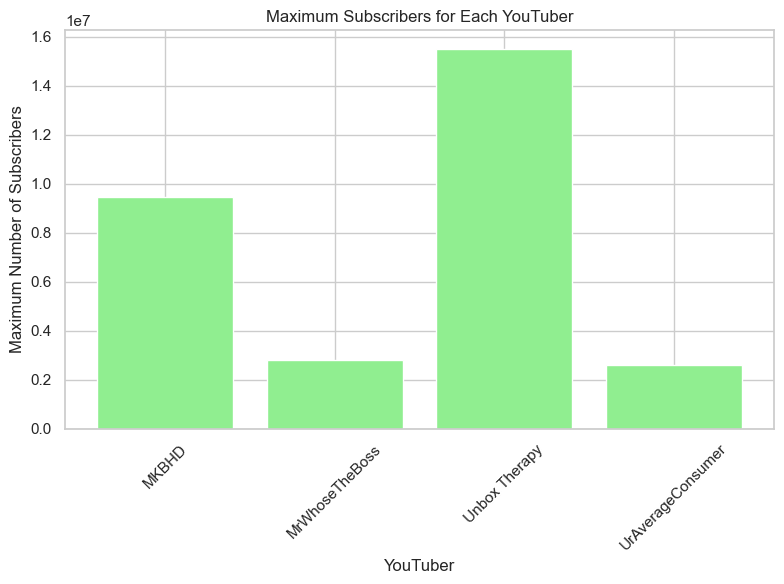

In [169]:
max_subscribers = combined_df.groupby('Youtuber')['subs'].max().reset_index()
plt.figure(figsize=(8, 6))
plt.bar(max_subscribers['Youtuber'], max_subscribers['subs'], color='lightgreen')
plt.xlabel('YouTuber')
plt.ylabel('Maximum Number of Subscribers')
plt.title('Maximum Subscribers for Each YouTuber')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability if needed
plt.tight_layout()

plt.show()


In this plot , we can observe that Unbox Therapy is the one with the most subscribers , followed by MKBHD, then UrAverageConsumer and MrWhoseTheBoss. Let's see if this ranking influences our study, and this agrees with the naive study when studying among wide cateogries.

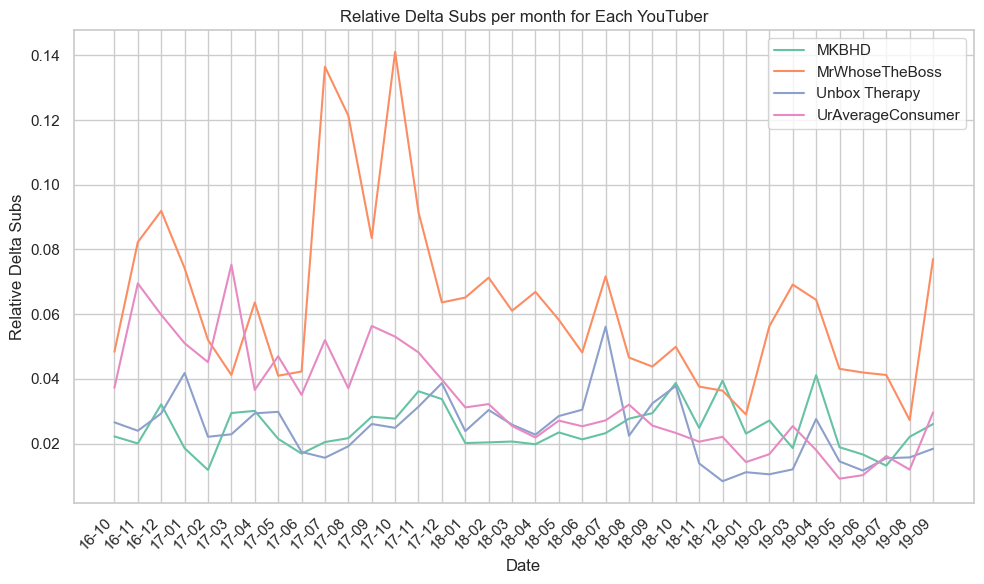

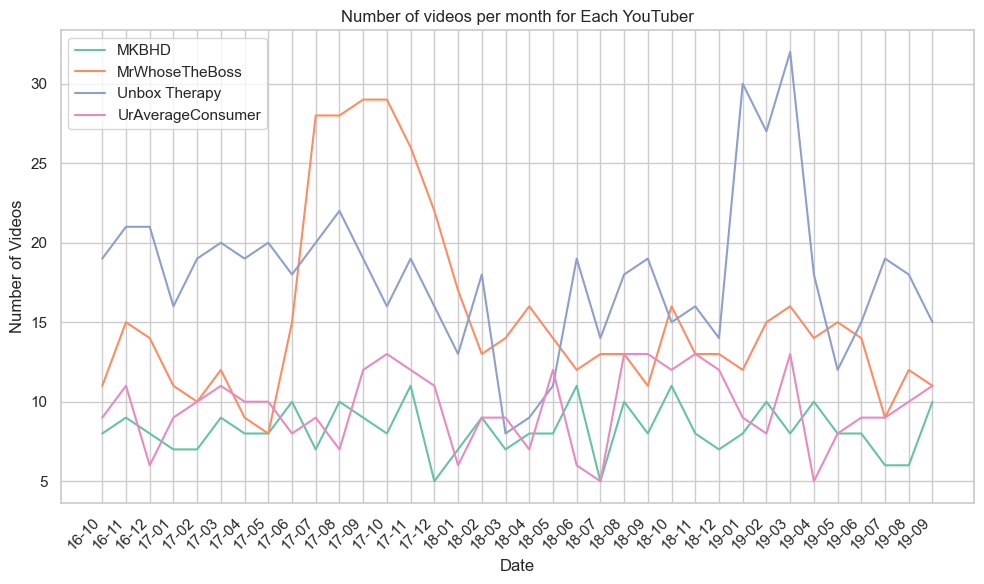

In [170]:

# Convert 'Year' and 'Month' to datetime format and create a new 'Date' column
combined_df['Date'] = pd.to_datetime(combined_df[['Year', 'Month']].assign(DAY=1))
# Format the 'Date' column as 'YY-MM'
combined_df['Date'] = combined_df['Date'].dt.strftime('%y-%m')
# Sort the DataFrame by the 'Date' column
combined_df = combined_df.sort_values(by='Date')
sns.set(style="whitegrid")
# Choose a color palette
palette = sns.color_palette("Set2")
# Assuming the necessary dataframes are defined

# Create a line plot for Relative Delta Subs
plt.figure(figsize=(10, 6))
for i, (youtuber, data) in enumerate(combined_df.groupby('Youtuber')):
    plt.plot(data['Date'], data['RelativeDeltaSubs'], label=youtuber, color=palette[i])

plt.title('Relative Delta Subs per month for Each YouTuber')
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Relative Delta Subs')
plt.legend()
plt.tight_layout()
plt.show()

# Create a line plot for Number of videos per month
plt.figure(figsize=(10, 6))
for i, (youtuber, data) in enumerate(combined_df.groupby('Youtuber')):
    plt.plot(data['Date'], data['Video_Count'], label=youtuber, color=palette[i])

plt.title('Number of videos per month for Each YouTuber')
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Videos')
plt.legend()
plt.tight_layout()
plt.show()

Here we can clearly observe a common trend that are shared by all youtubers, and that is pretty straightforward since pushing more videos per month will probably make you augment subscribers , since videos will appear more on the homepages of people.
I decided here to use relative delta subs instead of real deltasubs because we want to calculate a growth rate in terms of deltasubs, you are more likely to have more subscribers if you already have a lot of subscribers, hence we should divide by the total number of subs.

In [171]:
#calculate the correlation between delta videos and delta subs for MKBHD
print("MKBHD:")
MKBHDcorr = mergedMKBHD['Video_Count'].corr(mergedMKBHD['RelativeDeltaSubs'])
print(MKBHDcorr, '\n')


#calculate the correlation between delta videos and delta subs for Unbox Therapy
print("Unbox Therapy:")
Unboxcorr = mergedUnbox['Video_Count'].corr(mergedUnbox['RelativeDeltaSubs'])
print(Unboxcorr , '\n')

print("UrAverageConsumer:")
UrAvgcorr = mergedUrAvgConsumer['Video_Count'].corr(mergedUrAvgConsumer['RelativeDeltaSubs'])
print(UrAvgcorr , '\n')

print("MrWhoseTheBoss:")
Mrwhosethebosscorr = mergedMrwhosetheboss['Video_Count'].corr(mergedMrwhosetheboss['RelativeDeltaSubs'])
print(Mrwhosethebosscorr, '\n')


print('On average:')
print(combined_df['Video_Count'].corr(combined_df['RelativeDeltaSubs']))


MKBHD:
0.2936335807052104 

Unbox Therapy:
-0.2990995509724465 

UrAverageConsumer:
0.1774939368878631 

MrWhoseTheBoss:
0.7628583575997314 

On average:
0.34232653526978646


We can observe here that the number of videos submitted is really important for MrWhoseTheboss as 0.76 is a very significant correlation,that confirms the visual impression when seing the two plots. MKBHD has a not that significant correlation , but it's still positive and relevant, and justifies the same trend between number of videos and  the delta subs evolution. Overall, this positive correlation confirms what we will naturally think, the more videos you push the more subscribers you might got

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/2946812590.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='RelativeDeltaSubs', hue='Youtuber', data=combined_df, ci=None, ax=ax1, palette=youtuber_palette)
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/2946812590.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Monthly_Regularity', hue='Youtuber', data=combined_df, ci=None, ax=ax2, palette=youtuber_palette)


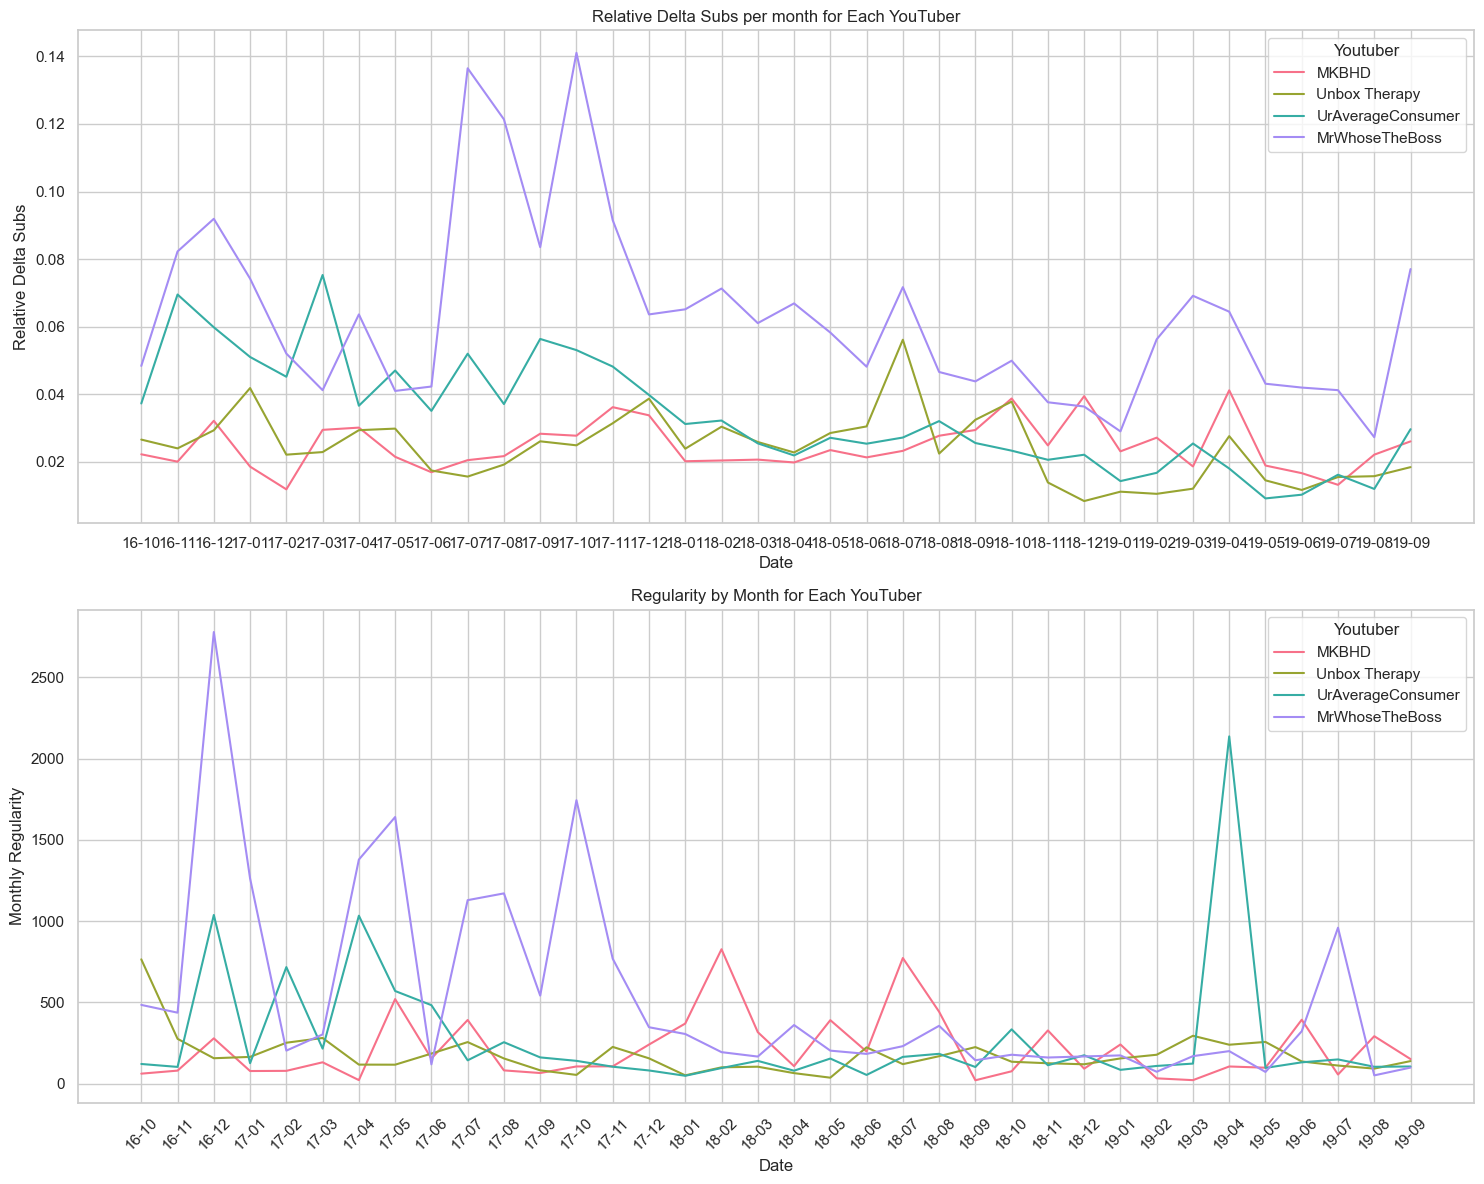

In [178]:

# Define a consistent palette for Youtubers
palette = sns.color_palette("Set2")

sns.set(style="whitegrid")

# Create subplots with a consistent palette
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)

# ---- First Subplot: Relative Delta Subs per month ----
sns.lineplot(x='Date', y='RelativeDeltaSubs', hue='Youtuber', data=combined_df, ci=None, ax=ax1, palette=youtuber_palette)
plt.xticks(rotation=45)
ax1.set_title('Relative Delta Subs per month for Each YouTuber')
ax1.set_ylabel('Relative Delta Subs')
ax1.legend(title='Youtuber')

# ---- Second Subplot: Average Upload Frequency per month ----
sns.lineplot(x='Date', y='Monthly_Regularity', hue='Youtuber', data=combined_df, ci=None, ax=ax2, palette=youtuber_palette)
ax2.set_title('Regularity by Month for Each YouTuber')
plt.xticks(rotation=45)
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Regularity')
ax2.legend(title='Youtuber')

# Adjust layout
plt.tight_layout()
plt.show()

We can clearly observe the same trend, this is to be explored more generally     

In [177]:

#print correlations for each youtuber between regularity and relative delta subs
print('MKBHD: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedMKBHD['Monthly_Regularity'].corr(mergedMKBHD['RelativeDeltaSubs']), '\n')
print('Unbox Therapy: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedUnbox['Monthly_Regularity'].corr(mergedUnbox['RelativeDeltaSubs']), '\n')
print('UrAverageConsumer: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedUrAvgConsumer['Monthly_Regularity'].corr(mergedUrAvgConsumer['RelativeDeltaSubs']), '\n')
print('MrWhoseTheBoss: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedMrwhosetheboss['Monthly_Regularity'].corr(mergedMrwhosetheboss['RelativeDeltaSubs']), '\n')


print('on average:')
print(combined_df['Monthly_Regularity'].corr(combined_df['RelativeDeltaSubs']))

MKBHD: Correlation between Monthly Regularity and Relative Delta Subs
-0.17412497452777903 

Unbox Therapy: Correlation between Monthly Regularity and Relative Delta Subs
-0.039021994429198834 

UrAverageConsumer: Correlation between Monthly Regularity and Relative Delta Subs
0.05630108487815437 

MrWhoseTheBoss: Correlation between Monthly Regularity and Relative Delta Subs
0.5398005184290603 

on average:
0.4704160212324767


What we can observe here is that there is a visible common trend for MrWhoseTheBoss ,and the Average Consumer. And specially for MrWhoseTheBoss.
And when we see the countplot above, this confirms that smaller youtubers need to upload a lot to improve and to evolve in terms of number of subscribers, The Average consumer , second to last in our set of 4 youtubers, has also a positive correlation (even if very small).
So on average, we might think that having a sustainable ryhtm and frequency of video uploads will help you to have more subscribers, and we want to explore this with a bigger set and generalize our study.